# Ensemble Strategy for Backtesting Stock Price

- This notebook runs the project [Ensemble_backtesting_stock_market](https://github.com/YeakubSadlil/Ensemble_backtesting_stock_market) . <br>
- ⚠️ It is designed to run only on **Google Colab** for faster training.To run it locally, data path may need to modify<br>
- We teseted our ensemble strategy here on 50 stocks for 5 years.
- Please remember to upload the [Data](https://github.com/YeakubSadlil/Ensemble_backtesting_stock_market/tree/main/Data/sp50/daily) and [ML Model](https://github.com/YeakubSadlil/Ensemble_backtesting_stock_market/blob/main/lstm_12_p50_ckp_13_24_e150.h5) files before running this notebook on Colab.
Paste the path cell below removing the default path.<br>
- It will take approximately 2.5 hours to run the default data of 50 assets for 5 years
- Open it on Google Colab or go [here](https://colab.research.google.com/drive/1O85HUaClIuqZwkVQjVrm8eyI1YPINQ29?usp=sharing)


In [ ]:
lstm_model_path = '/content/lstm_12_p50_ckp_13_24_e150.h5'
data_path = '/content/drive/MyDrive/Colab Notebooks/Data/sp50'

- Your dataset folder should have the last child folder named `daily`. But you shoudn't add the `daily` folder name in `data_path` <br>
- For ex: dataset path is `/content/drive/MyDrive/Colab Notebooks/Data/sp50/daily`<br>
extract it as: `/content/drive/MyDrive/Colab Notebooks/Data/sp50`

### Now you are ready to go, just click 'run all'

# Zipline installation

In [ ]:
# @title Default title text
%%capture
%%bash
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure
make
make install

In [ ]:
# @title Default title text
%%capture
%pip install zipline-reloaded

In [ ]:
# @title Quantstats Installation
%%capture
!pip install quantstats

In [ ]:
# @title Import Libraries
import numpy as np
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, order,record, order_target, get_open_orders,order_target_percent, order_percent,order_target_value
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions  # Zipline extensions are needed for listing sids
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
import talib
import yfinance as yf

import os
import sys
from datetime import datetime
from os.path import abspath
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

from sklearn.preprocessing import MinMaxScaler
from zipline.api import symbol, get_open_orders


# from hurst import compute_Hc

yf.pdr_override()

# Zipline imports
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order,
                         order_target,
                         order_value,
                         record,
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# ROOT_DIR = abspath('../')
# sys.path.append(ROOT_DIR)

Ingest data

In [ ]:
from zipline.data import bundles

bundle_name = 'sp50'

bundles.register(
    bundle_name,
    bundles.csvdir.csvdir_equities(
        ['daily'],
        data_path  # change the path for your data or upload it > https://github.com/YeakubSadlil/Ensemble_backtesting_stock_market/tree/main/Data/sp50/daily
    ),
    calendar_name='NYSE',
)

bundles.bundles

In [ ]:
bundles.ingest(bundle_name)

In [ ]:
bundle = 'sp50'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
sp50tickers = [coin.symbol for coin in assets]

### Funtions for Stategy Calculations

In [ ]:
# @title Module for generating signals

def calculate_bollinger_bands(prices, dev, window=20):
    """
    Calculate Bollinger Bands for a given series of prices.

    Parameters:
    - prices (pd.Series or np.array): Series of prices.
    - dev (float): Number of standard deviations to use for the bands.
    - window (int, optional): Rolling window size for calculating moving averages. Default is 20.

    Returns:
    - upper_band (float): Upper Bollinger Band.
    - sma (float): Simple Moving Average.
    - lower_band (float): Lower Bollinger Band.
    """

    sma = prices.mean()
    rolling_std = prices.std()
    upper_band = sma + (dev * rolling_std)
    lower_band = sma - (dev * rolling_std)
    return upper_band, sma, lower_band


def calculate_rsi(prices, window):
    """
    Calculate Relative Strength Index (RSI) for a given series of prices.

    Parameters:
    - prices (pd.Series or np.array): Series of prices.
    - window (int): Window size for calculating RSI.

    Returns:
    - rsi (pd.Series or np.array): Relative Strength Index values.
    """

    deltas = [prices[i + 1] - prices[i] for i in range(len(prices) - 1)]
    gains = [delta if delta > 0 else 0 for delta in deltas]
    losses = [-delta if delta < 0 else 0 for delta in deltas]

    avg_gain = sum(gains[:window]) / window
    avg_loss = sum(losses[:window]) / window

    rs = avg_gain / avg_loss if avg_loss != 0 else float("inf")
    rsi = 100 - (100 / (1 + rs))

    for i in range(window, len(prices) - 1):
        delta = prices[i + 1] - prices[i]
        gain = delta if delta > 0 else 0
        loss = -delta if delta < 0 else 0

        avg_gain = ((avg_gain * (window - 1)) + gain) / window
        avg_loss = ((avg_loss * (window - 1)) + loss) / window

        rs = avg_gain / avg_loss if avg_loss != 0 else float("inf")
        rsi.append(100 - (100 / (1 + rs)))

    return rsi


def calculate_atr(high_prices, low_prices, close_prices, period=14):
    """
    Calculate Average True Range (ATR) for a given series of high, low, and close prices.

    Parameters:
    - high_prices (pd.Series or np.array): Series of high prices.
    - low_prices (pd.Series or np.array): Series of low prices.
    - close_prices (pd.Series or np.array): Series of close prices.
    - period (int, optional): Period for calculating ATR. Default is 14.

    Returns:
    - atr (float): Average True Range.
    """

    high_low_diff = high_prices - low_prices
    high_close_diff = np.abs(high_prices - np.roll(close_prices, 1))
    low_close_diff = np.abs(low_prices - np.roll(close_prices, 1))
    true_range = np.maximum(high_low_diff, high_close_diff, low_close_diff)
    atr = np.mean(true_range[:period])
    for i in range(period, len(true_range)):
        atr = ((period - 1) * atr + true_range[i]) / period
    return atr


def plots(results):
    """
    Generate plots comparing strategy returns with a benchmark.

    Parameters:
    - results (pd.DataFrame): DataFrame containing strategy returns.

    Returns:
    - None
    """

    start = results.index[0]
    end = results.index[-1]
    benchmark = yf.download("^GSPC", start=start, end=end)["Adj Close"].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index
    qs.reports.full(
        results["returns"],
        benchmark=benchmark,
        match_dates=True,
        figsize=(8, 4),
        df=results
        # output='/content/asset50rsi_bg_without_lstm.html'
    )


def group1_ensemble_model_signals(context, data):
    """
    Generates trading signals based on the provided context and data.

    Parameters:
    - context: Context object containing necessary parameters.
    - data: Data object containing price data.

    Returns:
    - today_signal (dict): Signal for the last day for each ticker. It can take values [-1, 0, 1].
    """

    today_signal = {}

    for ticker in context.tickers:

        price_tomorrow = data.history(
            symbol(ticker), "price", bar_count=50, frequency="1d"
        )

        scaler = MinMaxScaler(feature_range=(0, 1))

        price_tomorrow = scaler.fit_transform(np.array(price_tomorrow).reshape(-1, 1))
        price_tomorrow = price_tomorrow.reshape(price_tomorrow.shape[1], price_tomorrow.shape[0], 1)

        predicted_price_tomorrow = scaler.inverse_transform(
            context.lstm_model.predict(price_tomorrow)
        )[0][0]


        prices = data.history(symbol(ticker), "price", context.window + 1, "1d")
        upper_band, mid_band, lower_band = calculate_bollinger_bands(
            prices, context.bollinger_dev, window=context.window
        )
        # rsi_value = calculate_rsi(prices, window=context.window)
        current_price = data.current(symbol(ticker), "price")
        open_orders = get_open_orders(ticker)

        signal = 0  # Default signal is hold

        if ticker not in open_orders:
            if (
                current_price < lower_band
                # and rsi_value < 30
                and predicted_price_tomorrow > current_price
                and ticker not in context.buy_stocks
            ):
                signal = 1  # Buy Signal
            elif (
                current_price > upper_band
                # and rsi_value > 70
                and predicted_price_tomorrow < current_price
                and ticker in context.buy_stocks
            ):
                signal = -1  # Sell Signal

        today_signal[ticker] = signal

    return today_signal


In [ ]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2022-12-31') # Backtesting for 1 year

BASE_CAPITAL = 100_000

## Backtesting

It will take approximately 2.5 hours to run the default data of 50 assets for 5 years time period

In [ ]:
#%%capture

import time
start_time = time.time()

def initialize(context):
    context.idx = 0
    context.tickers = sp50tickers
    context.window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05
    context.take_profit = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    context.current_date = None
    # upload the LSTM model file from https://github.com/YeakubSadlil/Ensemble_backtesting_stock_market/blob/main/lstm_12_p50_ckp_13_24_e150.h5
    context.lstm_model = load_model(lstm_model_path)
    context.model_window = 52

# Define the handle_data function
def handle_data(context, data):
    context.idx += 1
    if context.idx < context.model_window:
        return

    # Generate signals using groupx_ensemble_model_signals function which is the generate_signal.pymodule
    signal = group1_ensemble_model_signals(context, data)


    # Execute trades based on the generated signals
    for ticker, signal_value in signal.items():
        open_orders = get_open_orders(ticker)

        if ticker not in open_orders:
            if signal_value == 1 and ticker not in context.buy_stocks:
                if context.portfolio.cash > 0:
                    # print(signal)
                    order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
                    context.buy_stocks.add(ticker)

            elif signal_value == -1 and ticker in context.buy_stocks:
                order_target_percent(symbol(ticker), 0)  # Sell Signal
                context.buy_stocks.remove(ticker)


# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp50',
)


end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time for 50 assets: {inference_time:.6f} seconds")



Plot the performance of the ensemble strategy

[*********************100%%**********************]  1 of 1 completed


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-03-19   2018-03-19
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          39.52%       54.21%
Mean Active Return         0.0%         0.01%
CAGR﹪                     4.92%        6.45%

Sharpe                     0.43         0.49
Prob. Sharpe Ratio         82.28%       85.45%
Smart Sharpe               0.38         0.44
Sortino                    0.59         0.69
Smart Sortino              0.53         0.62
Sortino/√2                 0.42         0.49
Smart Sortino/√2           0.38         0.44
Omega                      1.1          1.1

Max Drawdown               -33.92%      -44.06%
Longest DD Days            361          410
Volatility (ann.)          22.01%       25.21%
R^2                        0.75         0.

0.014320187919205403



[Worst 5 Drawdowns]

    Start       Valley      End           Days    Max Drawdown    99% Max Drawdown
--  ----------  ----------  ----------  ------  --------------  ------------------
 1  2020-01-17  2020-03-23  2020-11-09     298         -44.059             -37.912
 2  2021-11-16  2022-10-12  2022-12-30     410         -28.063             -26.098
 3  2018-10-01  2018-12-24  2019-03-18     169         -20.276             -17.442
 4  2019-04-30  2019-05-31  2019-06-07      39          -7.285              -7.097
 5  2019-07-11  2019-08-14  2019-10-16      98          -6.625              -6.310



[Strategy Visualization]
via Matplotlib


Average Long Exposure = 118192.99971644163
Average Short Exposure = 0.0
Average Net Leverage = 0.8189833056309668
Average Gross Leverage = 0.8189833056309668
Max Leverage = 1.584195629449972



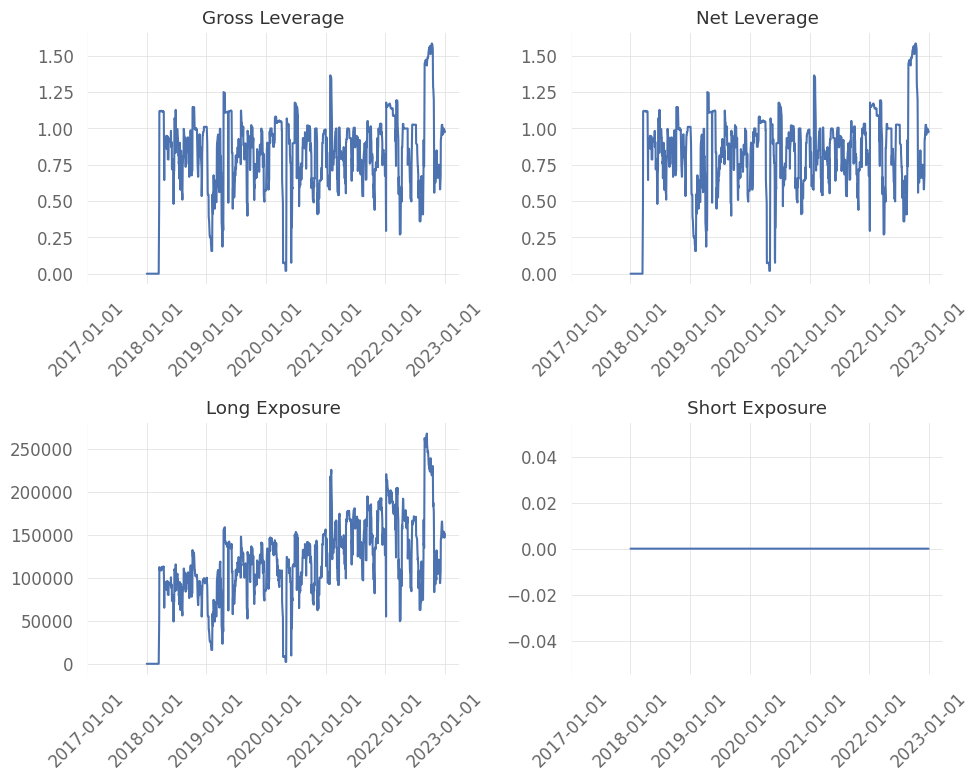

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS APA APD ARE AWK AXON BA BAC BAX BDX BG BKR BRK-B BX BXP CAT CCI CDNS CE CEG COF CPB CPT DIS EA FMC FOX GOOGL IFF KLAC LNT MMM MO NVDA STZ TECH TRGP VLO WBD WMB WMT


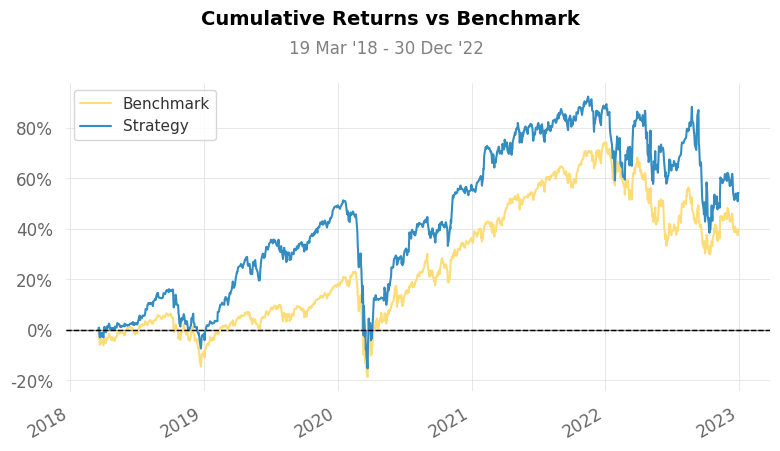

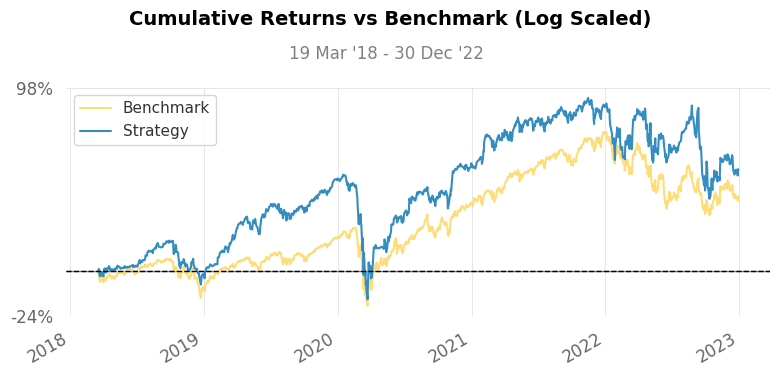

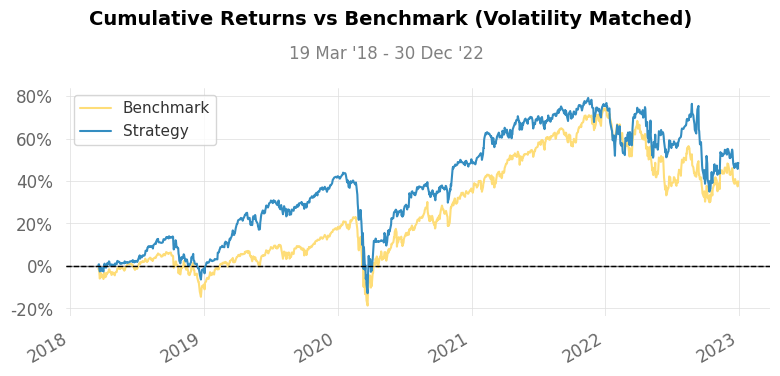

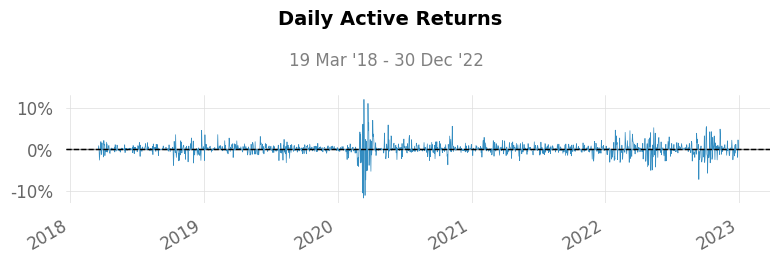

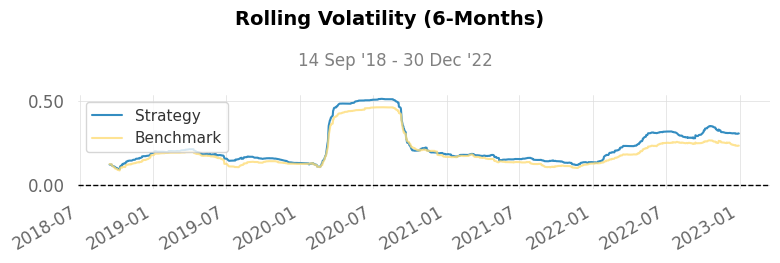

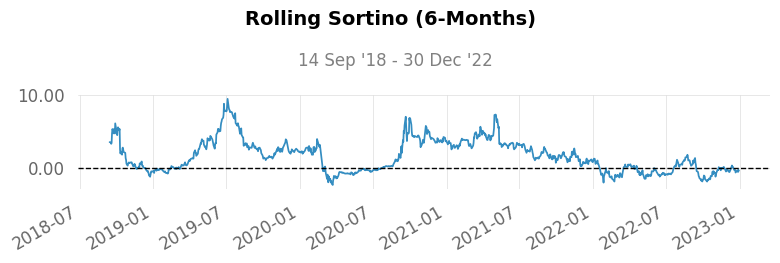

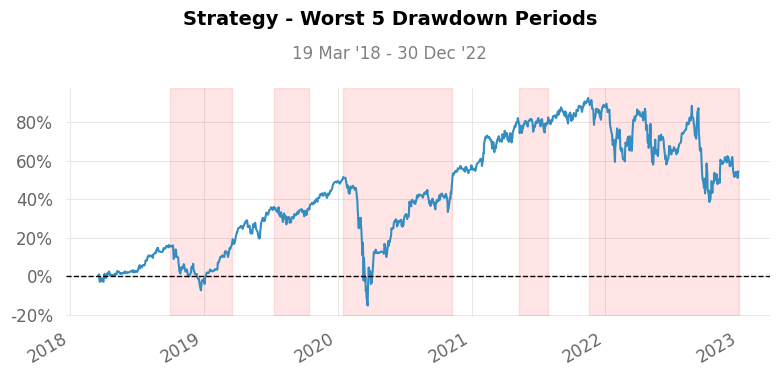

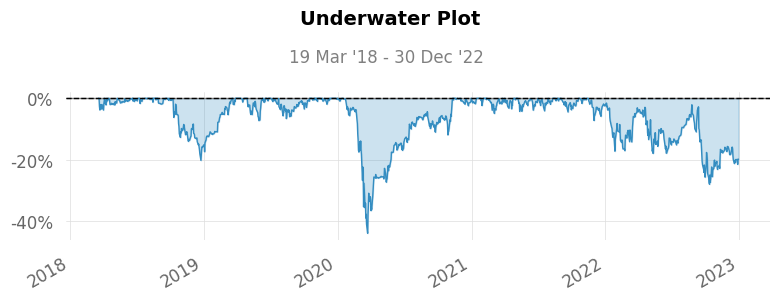

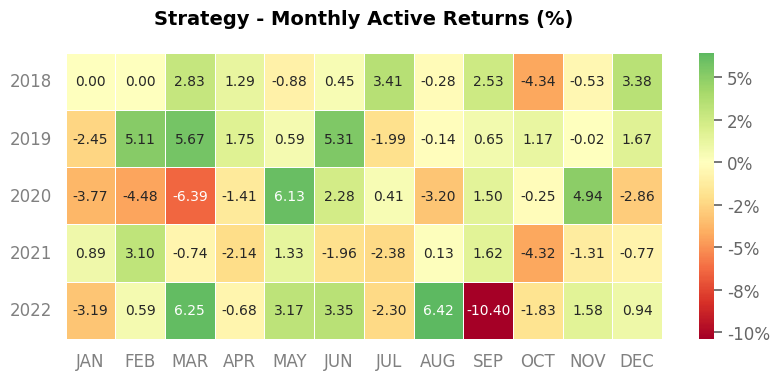

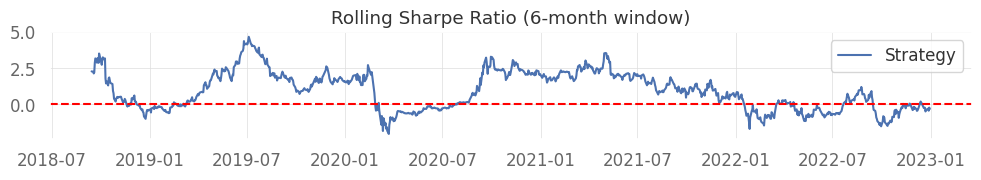

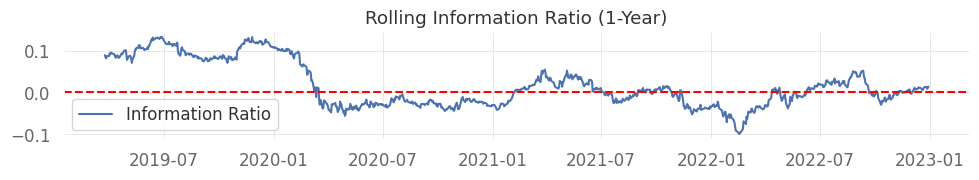

[*********************100%%**********************]  1 of 1 completed


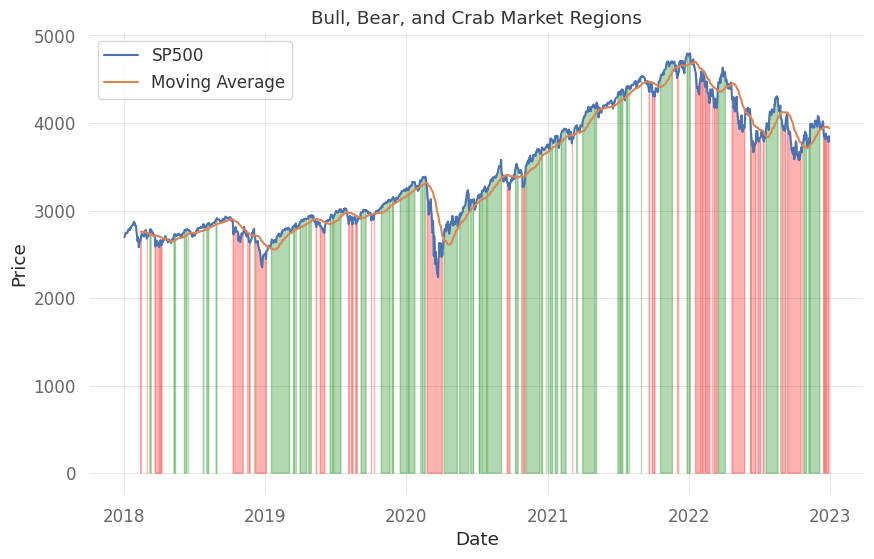

Total Trades: 1396
Daily Trades: 2
Weekly Trades: 10
Monthly Trades: 42





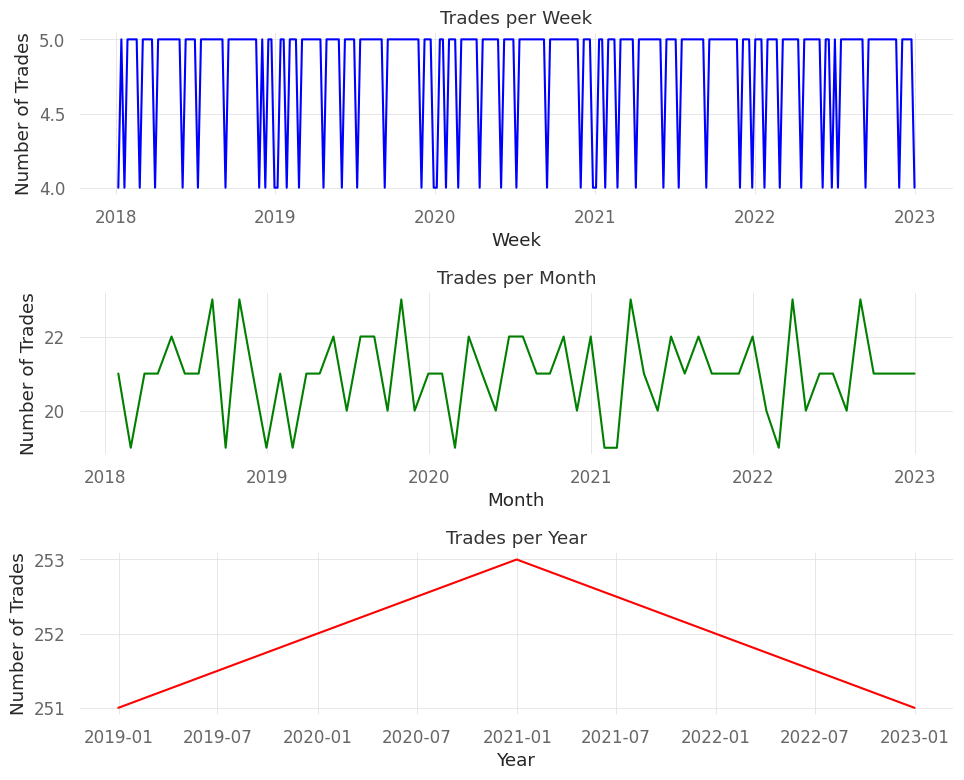

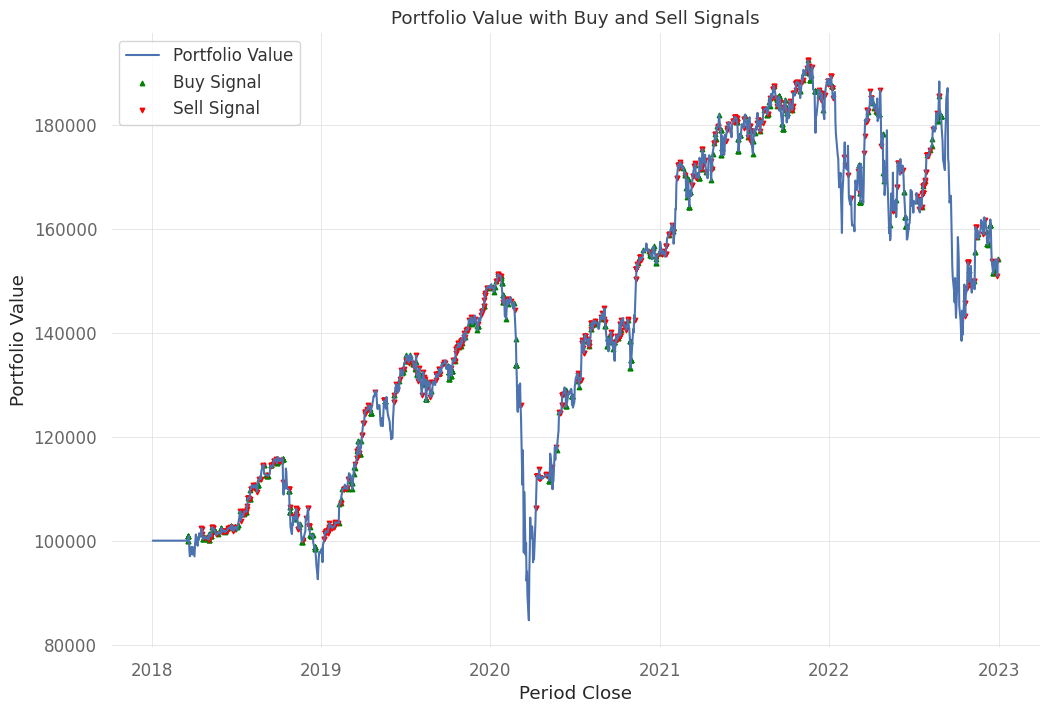

In [ ]:
plots(results)